In [1]:
from pathlib import Path 
import os, dotenv, yaml

with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

dotenv.load_dotenv()
os.chdir(Path(config["pythonpath"]).expanduser())

In [2]:
import numpy as np
import pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
import json

In [3]:
import subprocess
import pandas as pd

VARIATION = "nocomments"
VERSION = config["version"]
REPO_ROOT_DIR = Path(config["repo_root"]).expanduser()


MCC_ROOT_DIR = Path(config["mcc_root"]).expanduser()
MCC_ROOT_DIR.mkdir(parents=True, exist_ok=True)

clean_data_df = pd.read_json(
    f"data/clean_datasets/{VARIATION}_{VERSION}.jsonl", 
    lines=True
    )
meta_df = pd.read_json(f"data/clean_datasets/mcc_stats_{VARIATION}_{VERSION}.jsonl", lines=True)

In [4]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   filename                   832 non-null    object 
 1   json_path                  832 non-null    object 
 2   imports                    832 non-null    object 
 3   imports_count              832 non-null    int64  
 4   num_definitions            832 non-null    int64  
 5   num_declarations           832 non-null    int64  
 6   num_types                  832 non-null    int64  
 7   num_declarations_with_mcc  832 non-null    int64  
 8   total_mcc                  832 non-null    int64  
 9   max_mcc                    832 non-null    int64  
 10  avg_mcc                    832 non-null    float64
 11  avg_mcc_difficulty_bucket  832 non-null    int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 78.1+ KB


In [5]:
source_meta_df = meta_df[~meta_df["filename"].astype(str).str.startswith("cryptol_slices/")].copy()
slice_meta_df = meta_df[meta_df["filename"].astype(str).str.startswith("cryptol_slices/")].copy()

source_meta_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 375 entries, 0 to 374
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   filename                   375 non-null    object 
 1   json_path                  375 non-null    object 
 2   imports                    375 non-null    object 
 3   imports_count              375 non-null    int64  
 4   num_definitions            375 non-null    int64  
 5   num_declarations           375 non-null    int64  
 6   num_types                  375 non-null    int64  
 7   num_declarations_with_mcc  375 non-null    int64  
 8   total_mcc                  375 non-null    int64  
 9   max_mcc                    375 non-null    int64  
 10  avg_mcc                    375 non-null    float64
 11  avg_mcc_difficulty_bucket  375 non-null    int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 38.1+ KB


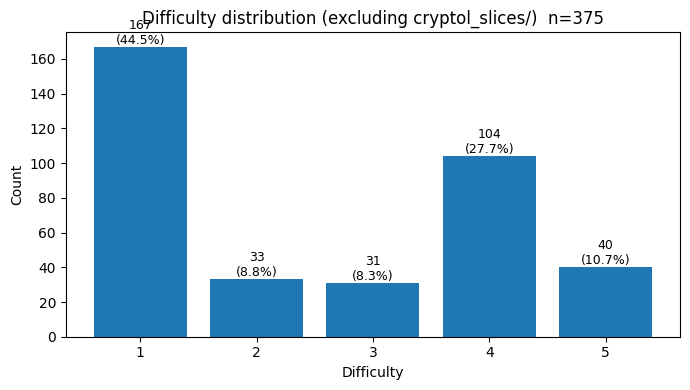

avg_mcc_difficulty_bucket
1    167
2     33
3     31
4    104
5     40
Name: count, dtype: int64


In [6]:
bucket_col = "avg_mcc_difficulty_bucket"

# 2) Count distribution (sorted)
counts = (
    source_meta_df[bucket_col]
    .dropna()
    .value_counts()
    .sort_index()
)

# Optional: show percentages
pct = counts / counts.sum() * 100

# 3) Bar plot
plt.figure(figsize=(7, 4))
plt.bar(counts.index.astype(str), counts.values)

plt.xlabel("Difficulty")
plt.ylabel("Count")
plt.title(f"Difficulty distribution (excluding cryptol_slices/)  n={counts.sum()}")

# Add count + % labels on top of bars
for i, (k, v) in enumerate(counts.items()):
    plt.text(i, v, f"{v}\n({pct.loc[k]:.1f}%)", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

print(counts)

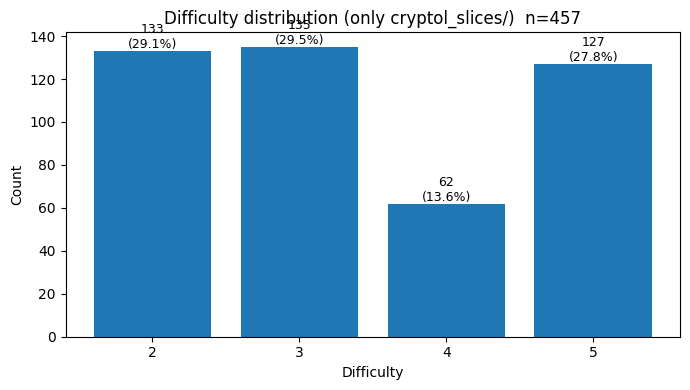

avg_mcc_difficulty_bucket
2    133
3    135
4     62
5    127
Name: count, dtype: int64


In [7]:

# 2) Count distribution (sorted)
counts = (
    slice_meta_df[bucket_col]
    .dropna()
    .value_counts()
    .sort_index()
)

# Optional: show percentages
pct = counts / counts.sum() * 100

# 3) Bar plot
plt.figure(figsize=(7, 4))
plt.bar(counts.index.astype(str), counts.values)

plt.xlabel("Difficulty")
plt.ylabel("Count")
plt.title(f"Difficulty distribution (only cryptol_slices/)  n={counts.sum()}")

# Add count + % labels on top of bars
for i, (k, v) in enumerate(counts.items()):
    plt.text(i, v, f"{v}\n({pct.loc[k]:.1f}%)", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

print(counts)

In [17]:
from sklearn.model_selection import train_test_split
from pathlib import PurePosixPath


AUG_PREFIX = "cryptol_slices/"

def infer_source_id(filename: str) -> str:
    p = PurePosixPath(str(filename).replace("\\", "/"))

    # If it's augmented: strip the leading cryptol_slices/
    if str(p).startswith(AUG_PREFIX):
        p = PurePosixPath(str(p)[len(AUG_PREFIX):])
    else:
        return filename
    # parent directory name (e.g., ".../bivium")
    parent = p.parent

    # append ".cry" to the directory path (e.g., ".../bivium.cry")
    return str(parent.with_suffix(".cry"))

meta_df["source_id"] = meta_df["filename"].apply(infer_source_id)

source_meta_df["source_id"] = source_meta_df["filename"].apply(infer_source_id)
print(len(meta_df["source_id"].unique()))
print(len(source_meta_df["source_id"].unique()))


375
375


In [19]:
SEED = 42

TRAIN_FRAC = 0.80
VAL_FRAC   = 0.10
TEST_FRAC  = 0.10

groups = (
    source_meta_df[["source_id", bucket_col]]
    .dropna(subset=[bucket_col])
    .drop_duplicates("source_id")
)
groups[bucket_col] = groups[bucket_col].astype(int)

train_groups, temp_groups = train_test_split(
    groups,
    test_size=(1.0 - TRAIN_FRAC),
    stratify=groups[bucket_col],
    random_state=SEED,
    shuffle=True,
)

val_share_of_temp = VAL_FRAC / (VAL_FRAC + TEST_FRAC)  # e.g. 0.5 if 10/10
val_groups, test_groups = train_test_split(
    temp_groups,
    test_size=(1.0 - val_share_of_temp),
    stratify=temp_groups[bucket_col],
    random_state=SEED,
    shuffle=True,
)

train_ids = set(train_groups["source_id"])
val_ids   = set(val_groups["source_id"])
test_ids  = set(test_groups["source_id"])

meta_df["split"] = np.select(
    [
        meta_df["source_id"].isin(train_ids),
        meta_df["source_id"].isin(val_ids),
        meta_df["source_id"].isin(test_ids),
    ],
    ["train", "val", "test"],
    default=pd.NA
)


Counts:


avg_mcc_difficulty_bucket,1,2,3,4,5
split,,,,,
train,134,144,141,137,141
val,16,9,12,12,15
test,17,13,13,17,11


Percentages:


avg_mcc_difficulty_bucket,1,2,3,4,5
split,,,,,
train,19.2,20.7,20.2,19.7,20.2
val,25.0,14.1,18.8,18.8,23.4
test,23.9,18.3,18.3,23.9,15.5


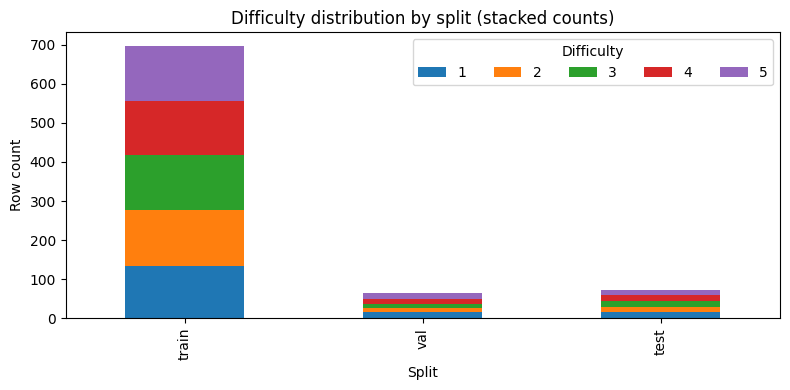

In [23]:
# Counts: split × difficulty
counts = (
    meta_df
    .groupby(["split", bucket_col])
    .size()
    .unstack(fill_value=0)
    .reindex(index=["train", "val", "test"])  # nice order
    .sort_index(axis=1)                       # difficulty 1..5
)

print("Counts:")
display(counts)

# Percentages within each split (often easier to compare)
pct = (counts.div(counts.sum(axis=1), axis=0) * 100).round(1)
print("Percentages:")
display(pct)

# Stacked bar (counts)
ax = counts.plot(kind="bar", stacked=True, figsize=(8, 4))
ax.set_xlabel("Split")
ax.set_ylabel("Row count")
ax.set_title("Difficulty distribution by split (stacked counts)")
ax.legend(title="Difficulty", ncols=5)
plt.tight_layout()
plt.show()

In [25]:
meta_df.drop(columns=["source_id"]).to_json(f"data/clean_datasets/mcc_stats_{VARIATION}_{VERSION}.jsonl", orient="records", lines=True)